# Data preparation

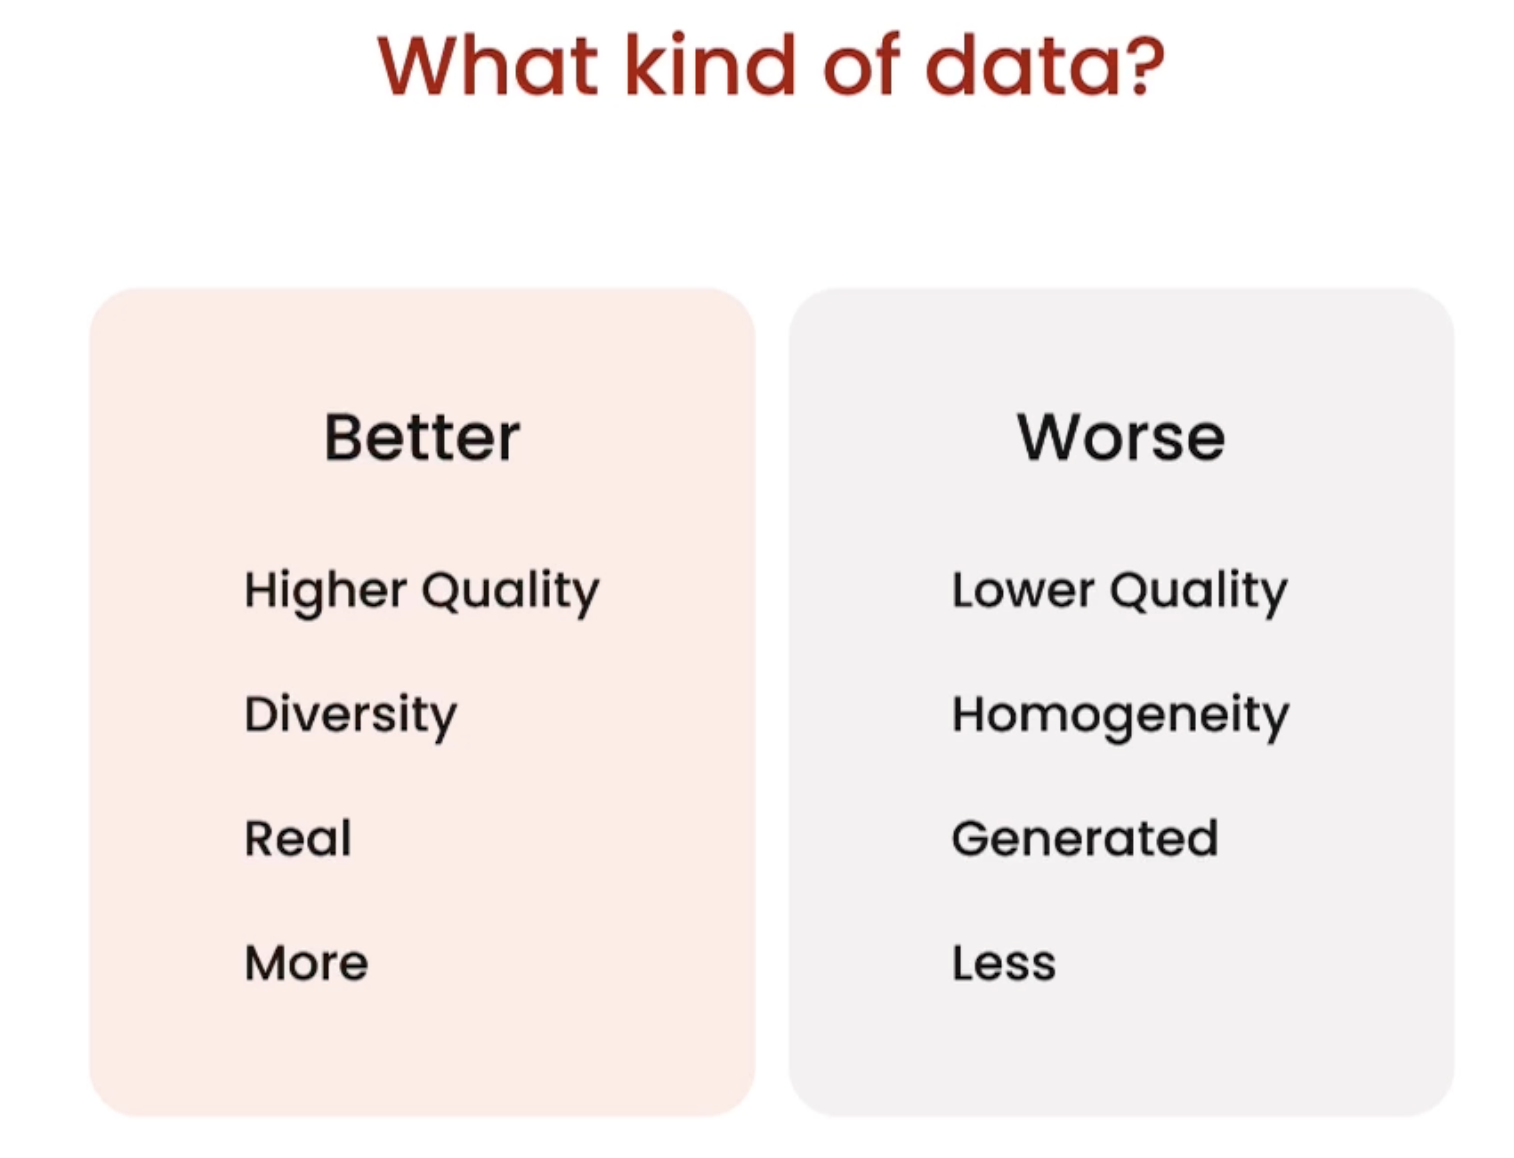
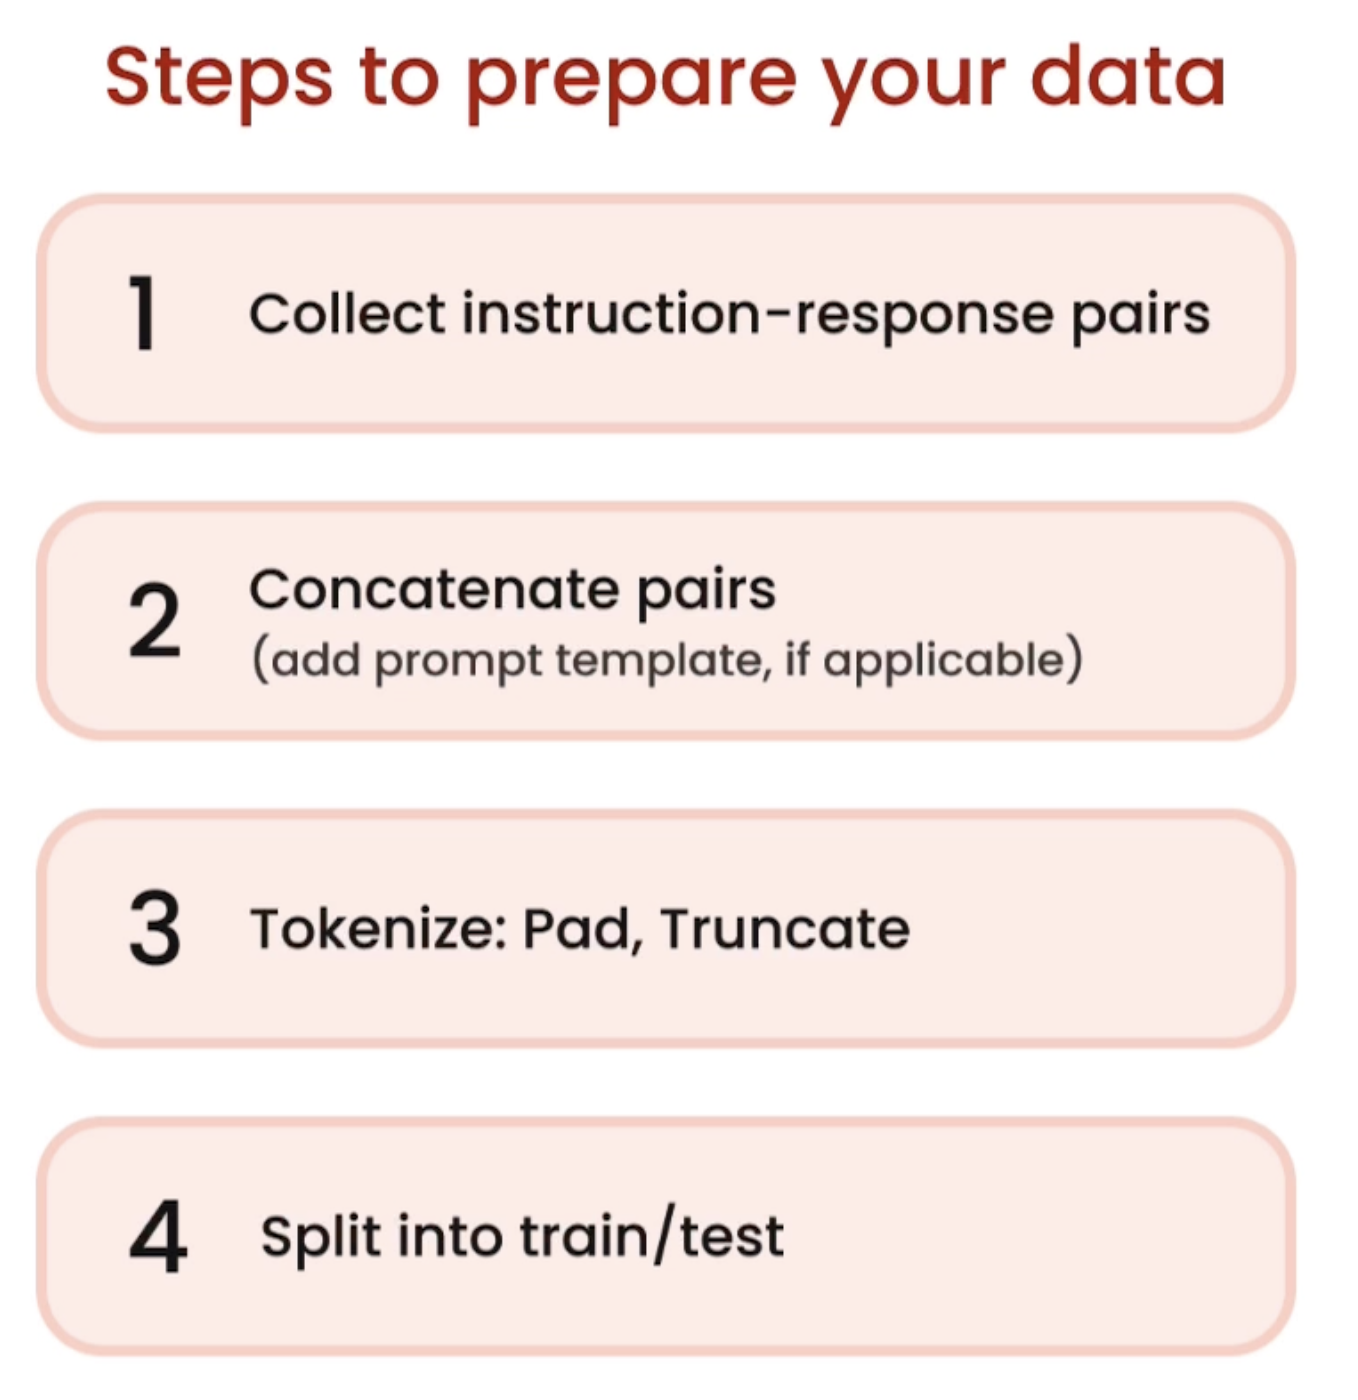
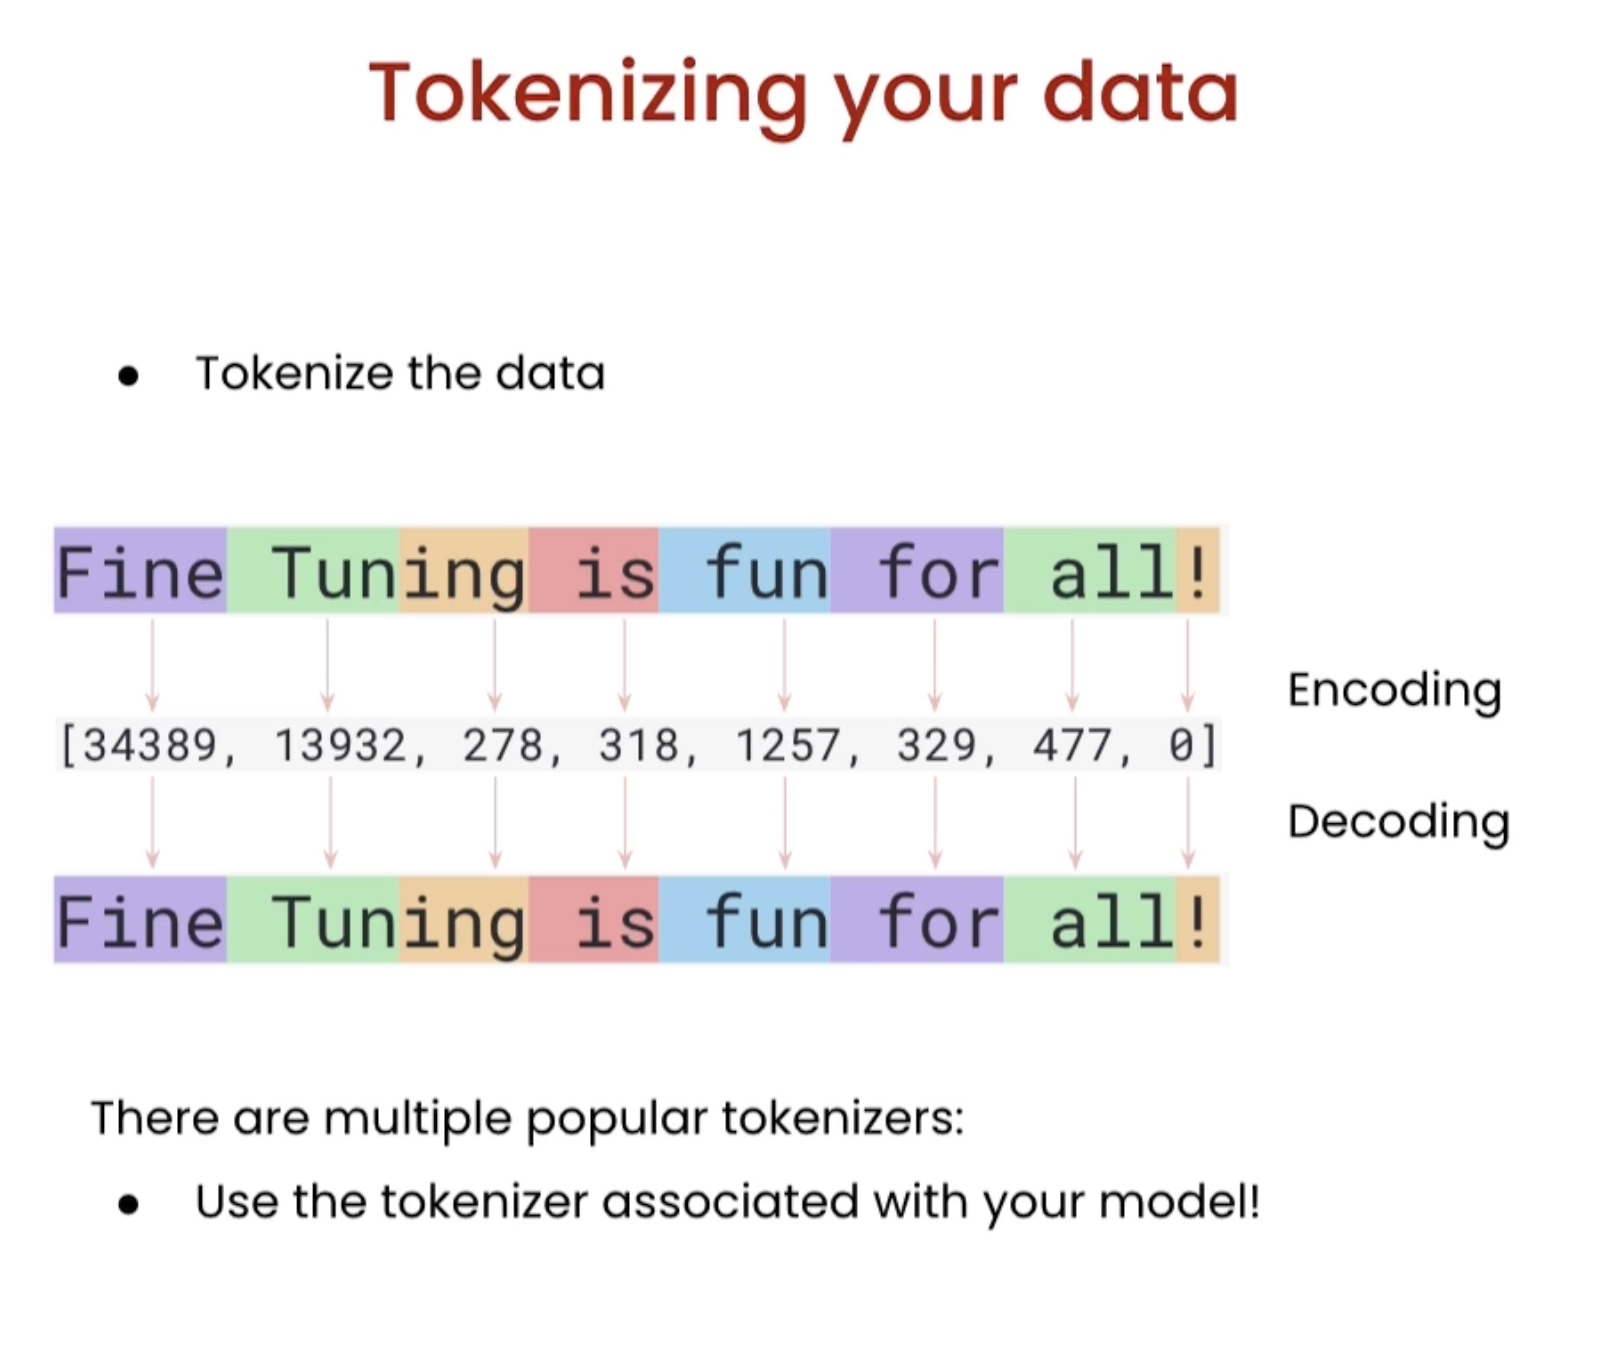

In [1]:
import pandas as pd
import datasets

from pprint import pprint
from transformers import AutoTokenizer # from huggingface transformers library

### Tokenizing text

In [2]:
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-70m")

tokenizer_config.json:   0%|          | 0.00/396 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

In [3]:
text = "Hi, how are you?"

In [4]:
encoded_text = tokenizer(text)["input_ids"]

In [5]:
encoded_text

[12764, 13, 849, 403, 368, 32]

In [6]:
decoded_text = tokenizer.decode(encoded_text)
print("Decoded tokens back into text: ", decoded_text)

Decoded tokens back into text:  Hi, how are you?


### Tokenize multiple texts at once

In [7]:
list_texts = ["Hi, how are you?", "I'm good", "Yes"]
encoded_texts = tokenizer(list_texts)
print("Encoded several texts: ", encoded_texts["input_ids"])

Encoded several texts:  [[12764, 13, 849, 403, 368, 32], [42, 1353, 1175], [4374]]


### Padding and truncation -- to avoid varying length

In [8]:
tokenizer.pad_token = tokenizer.eos_token 
encoded_texts_longest = tokenizer(list_texts, padding=True)
print("Using padding: ", encoded_texts_longest["input_ids"])

Using padding:  [[12764, 13, 849, 403, 368, 32], [42, 1353, 1175, 0, 0, 0], [4374, 0, 0, 0, 0, 0]]


In [9]:
encoded_texts_truncation = tokenizer(list_texts, max_length=3, truncation=True)
print("Using truncation: ", encoded_texts_truncation["input_ids"])

Using truncation:  [[12764, 13, 849], [42, 1353, 1175], [4374]]


In [10]:
tokenizer.truncation_side = "left"
encoded_texts_truncation_left = tokenizer(list_texts, max_length=3, truncation=True)
print("Using left-side truncation: ", encoded_texts_truncation_left["input_ids"])

Using left-side truncation:  [[403, 368, 32], [42, 1353, 1175], [4374]]


In [11]:
encoded_texts_both = tokenizer(list_texts, max_length=3, truncation=True, padding=True)
print("Using both padding and truncation: ", encoded_texts_both["input_ids"])

Using both padding and truncation:  [[403, 368, 32], [42, 1353, 1175], [4374, 0, 0]]


### Prepare instruction dataset

In [12]:
import pandas as pd

filename = "lamini_docs.jsonl"
instruction_dataset_df = pd.read_json(filename, lines=True)
examples = instruction_dataset_df.to_dict()

if "question" in examples and "answer" in examples:
  text = examples["question"][0] + examples["answer"][0]
elif "instruction" in examples and "response" in examples:
  text = examples["instruction"][0] + examples["response"][0]
elif "input" in examples and "output" in examples:
  text = examples["input"][0] + examples["output"][0]
else:
  text = examples["text"][0]

prompt_template = """### Question:
{question}

### Answer:"""

num_examples = len(examples["question"])
finetuning_dataset = []
for i in range(num_examples):
  question = examples["question"][i]
  answer = examples["answer"][i]
  text_with_prompt_template = prompt_template.format(question=question)
  finetuning_dataset.append({"question": text_with_prompt_template, "answer": answer})

from pprint import pprint
print("One datapoint in the finetuning dataset:")
pprint(finetuning_dataset[0])

One datapoint in the finetuning dataset:
{'answer': 'Lamini has documentation on Getting Started, Authentication, '
           'Question Answer Model, Python Library, Batching, Error Handling, '
           'Advanced topics, and class documentation on LLM Engine available '
           'at https://lamini-ai.github.io/.',
 'question': '### Question:\n'
             'What are the different types of documents available in the '
             'repository (e.g., installation guide, API documentation, '
             "developer's guide)?\n"
             '\n'
             '### Answer:'}


### Tokenize a single example

In [13]:
text = finetuning_dataset[0]["question"] + finetuning_dataset[0]["answer"]
tokenized_inputs = tokenizer(
    text,
    return_tensors="np",
    padding=True
)
print(tokenized_inputs["input_ids"])

[[ 4118 19782    27   187  1276   403   253  1027  3510   273  7177  2130
    275   253 18491   313    70    15    72   904 12692  7102    13  8990
  10097    13 13722   434  7102  6177   187   187  4118 37741    27    45
   4988    74   556 10097   327 27669 11075   264    13  5271 23058    13
  19782 37741 10031    13 13814 11397    13   378 16464    13 11759 10535
   1981    13 21798 12989    13   285   966 10097   327 21708    46 10797
   2130   387  5987  1358    77  4988    74    14  2284    15  7280    15
    900 14206]]


In [14]:
max_length = 2048
max_length = min(
    tokenized_inputs["input_ids"].shape[1],
    max_length,
)

In [15]:
tokenized_inputs = tokenizer(
    text,
    return_tensors="np",
    truncation=True,
    max_length=max_length
)

In [16]:
tokenized_inputs["input_ids"]

array([[ 4118, 19782,    27,   187,  1276,   403,   253,  1027,  3510,
          273,  7177,  2130,   275,   253, 18491,   313,    70,    15,
           72,   904, 12692,  7102,    13,  8990, 10097,    13, 13722,
          434,  7102,  6177,   187,   187,  4118, 37741,    27,    45,
         4988,    74,   556, 10097,   327, 27669, 11075,   264,    13,
         5271, 23058,    13, 19782, 37741, 10031,    13, 13814, 11397,
           13,   378, 16464,    13, 11759, 10535,  1981,    13, 21798,
        12989,    13,   285,   966, 10097,   327, 21708,    46, 10797,
         2130,   387,  5987,  1358,    77,  4988,    74,    14,  2284,
           15,  7280,    15,   900, 14206]])

### Tokenize the instruction dataset

In [17]:
def tokenize_function(examples):
    if "question" in examples and "answer" in examples:
      text = examples["question"][0] + examples["answer"][0]
    elif "input" in examples and "output" in examples:
      text = examples["input"][0] + examples["output"][0]
    else:
      text = examples["text"][0]

    tokenizer.pad_token = tokenizer.eos_token
    tokenized_inputs = tokenizer(
        text,
        return_tensors="np",
        padding=True,
    )

    max_length = min(
        tokenized_inputs["input_ids"].shape[1],
        2048
    )
    tokenizer.truncation_side = "left"
    tokenized_inputs = tokenizer(
        text,
        return_tensors="np",
        truncation=True,
        max_length=max_length
    )

    return tokenized_inputs

In [18]:
finetuning_dataset_loaded = datasets.load_dataset("json", data_files=filename, split="train")

tokenized_dataset = finetuning_dataset_loaded.map(
    tokenize_function,
    batched=True,
    batch_size=1,
    drop_last_batch=True
)

print(tokenized_dataset)

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/1400 [00:00<?, ? examples/s]

Dataset({
    features: ['question', 'answer', 'input_ids', 'attention_mask'],
    num_rows: 1400
})


In [19]:
tokenized_dataset = tokenized_dataset.add_column("labels", tokenized_dataset["input_ids"])

### Prepare test/train splits

In [20]:
split_dataset = tokenized_dataset.train_test_split(test_size=0.1, shuffle=True, seed=123)
print(split_dataset)

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1260
    })
    test: Dataset({
        features: ['question', 'answer', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 140
    })
})


### Some datasets for you to try

In [21]:
finetuning_dataset_path = "lamini/lamini_docs"
finetuning_dataset = datasets.load_dataset(finetuning_dataset_path)
print(finetuning_dataset)

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1260
    })
    test: Dataset({
        features: ['question', 'answer', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 140
    })
})


In [22]:
taylor_swift_dataset = "lamini/taylor_swift"
bts_dataset = "lamini/bts"
open_llms = "lamini/open_llms"

In [23]:
dataset_swiftie = datasets.load_dataset(taylor_swift_dataset)
print(dataset_swiftie["train"][1])

README.md:   0%|          | 0.00/573 [00:00<?, ?B/s]

(…)-00000-of-00001-54dd04266a81dbc7.parquet:   0%|          | 0.00/257k [00:00<?, ?B/s]

(…)-00000-of-00001-185d72ed4b72e469.parquet:   0%|          | 0.00/46.3k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/783 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/87 [00:00<?, ? examples/s]

{'question': 'What is the most popular Taylor Swift song among millennials? How does this song relate to the millennial generation? What is the significance of this song in the millennial culture?', 'answer': 'Taylor Swift\'s "Shake It Off" is the most popular song among millennials. This song relates to the millennial generation as it is an anthem of self-acceptance and embracing one\'s individuality. The song\'s message of not letting others bring you down and to just dance it off resonates with the millennial culture, which is often characterized by a strong sense of individuality and a rejection of societal norms. Additionally, the song\'s upbeat and catchy melody makes it a perfect fit for the millennial generation, which is known for its love of pop music.', 'input_ids': [1276, 310, 253, 954, 4633, 11276, 24619, 4498, 2190, 24933, 8075, 32, 1359, 1057, 436, 4498, 14588, 281, 253, 24933, 451, 5978, 32, 1737, 310, 253, 8453, 273, 436, 4498, 275, 253, 24933, 451, 4466, 32, 37979, 24

In [ ]:
# This is how to push your own dataset to your Huggingface hub
# !pip install huggingface_hub
# !huggingface-cli login
# split_dataset.push_to_hub(dataset_path_hf)